In [18]:
import sys
sys.path.append("../")

import os
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy import stats
import engarde.decorators as ed

import statsmodels.formula.api as smf
from linearmodels import PanelOLS
#from library import test

from matplotlib import lines, markers
from cycler import cycler

pd.set_option('mode.chained_assignment', None)

In [19]:
data_path = '/Users/kylieleblancKylie/domino/dofis/data/'
table_path = '/Users/kylieleblancKylie/domino/dofis/results/Who Needs Rules/'
data = pd.read_csv(os.path.join(data_path, 'clean', 'gdid_subject.csv'),
                  sep=",", low_memory= False)
data.sample()

,Unnamed: 0,campus,year,test,score,score_std,campname,campischarter,district,distname,...,pre5,pre4,pre3,pre2,pre1,pre0,post1,post2,post3,test_by_year
51343,63606,57905018,2016,bio_avescore,4066.0,-0.004877,SUNSET H S,N,57905,DALLAS ISD,...,0,0,0,1,0,0,0,0,0,bio_avescore2016


In [26]:
data.doi_year.value_counts()

2018.0    133956
2017.0     89082
2019.0     30453
2020.0      2906
Name: doi_year, dtype: int64

# Graph by year of implementation

In [20]:
def create_group_df(df, outcome):
    df['outcome'] = df[outcome]
    new_df = pd.DataFrame(df.groupby(['year']).agg({'outcome': ['mean', 'sem']}))
    new_df = new_df.rename(columns = {'mean': 'outcome_mean', 'sem': 'outcome_se'})
    new_df['ub'] = new_df['outcome']['outcome_mean'] + new_df['outcome']['outcome_se']
    new_df['lb'] = new_df['outcome']['outcome_mean'] - new_df['outcome']['outcome_se']
    return new_df

In [59]:
def parallel_trends_graph(outcome, title, subject, graph_title):
    
    if subject == '':
        df_treat2017 = create_group_df(data[data.doi_year == 2017], outcome = outcome)
        df_treat2018 = create_group_df(data[data.doi_year == 2018], outcome = outcome)
        df_treat2019 = create_group_df(data[data.doi_year == 2019], outcome = outcome)
    
    else:
        # Create cycler object. Use any styling from above you please
        df_treat2017 = create_group_df(data[data.doi_year == 2017][data.test == subject], outcome = outcome)
        df_treat2018 = create_group_df(data[data.doi_year == 2018][data.test == subject], outcome = outcome)
        df_treat2019 = create_group_df(data[data.doi_year == 2019][data.test == subject], outcome = outcome)

    monochrome = (cycler('color', ['k']) * cycler('linestyle', ['-', '--', ':', '=.']))

    fig, ax = plt.subplots(1,1)
    ax.set_prop_cycle(monochrome)

    ax.plot(list(df_treat2017.index), df_treat2017['outcome']['outcome_mean'], label = '2016-17 DOI Implementers')
    ax.plot(list(df_treat2018.index), df_treat2018['outcome']['outcome_mean'],label = '2017-18 DOI Implementers')
    ax.plot(list(df_treat2019.index), df_treat2019['outcome']['outcome_mean'], label = '2018-19 DOI Implementers')

    ax.legend()


    ax.fill_between(list(df_treat2017.index), df_treat2017.lb, df_treat2017.ub, alpha = .2)
    ax.fill_between(list(df_treat2018.index), df_treat2018.lb, df_treat2018.ub, alpha = .2)
    ax.fill_between(list(df_treat2019.index), df_treat2019.lb, df_treat2019.ub, alpha = .2)

    ax.axvline(x = 2016.5, linestyle = '-', color = 'black')
    ax.axvline(x = 2017.5, linestyle = '--', color = 'black')
    ax.axvline(x = 2018.5, linestyle = ':', color = 'black')

    ax.set_title(graph_title)
    ax.grid(False)

    #ax.set_ylim(-.5, .5)
    

    fig.savefig(table_path + title + subject + '.png', bbox_inches="tight")

## Parallel Trends

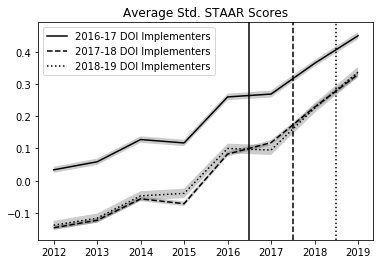

In [60]:
parallel_trends_graph('score_std', 'trends_by_adoption_score_std', '', 'Average Std. STAAR Scores')

#### One possible exemption in parallel trends comes between 2014-15 for the 2018-19 implementers. While other groups decrease, this group of districts see an increase in trends.

did_df = data[(data.year == 2014) | (data.year == 2015)]
did_df['treat_placebo'] = np.where(did_df.doi_year == 2018, 1, 0)
did_df['post_placebo'] = np.where(did_df.year > 2014, 1, 0)
did_df['treat_post_placebo'] = did_df.treat_placebo * did_df.post_placebo

did_df = did_df.reset_index()
did_df['year'] = pd.to_datetime(did_df['year'], format='%Y')
#add column year to index
did_df = did_df.set_index(['year', 'campus'])
#swap indexes
did_df.index = did_df.index.swaplevel(0,1)
did_df[['district', 'doi_year','treat_placebo', 'post_placebo', 'treat_post_placebo']].sample(5)

change_2016 = df_treat2016['outcome']['outcome_mean'].loc[2015] - df_treat2016['outcome']['outcome_mean'].loc[2014]
print(change_2016)
change_2017 = df_treat2017['outcome']['outcome_mean'].loc[2015] - df_treat2017['outcome']['outcome_mean'].loc[2014]
print(change_2017)
change_2018 = df_treat2018['outcome']['outcome_mean'].loc[2015] - df_treat2018['outcome']['outcome_mean'].loc[2014]
print(change_2018)

mod = PanelOLS.from_formula('score_std ~ 1 + treat_placebo + post_placebo + treat_post_placebo', did_df)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

# Graph by subject

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


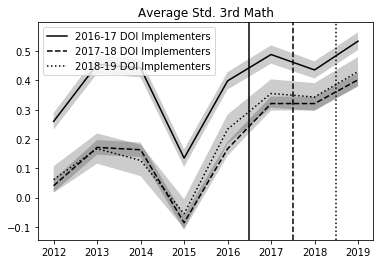

In [61]:
subjects = ['m_3rd_avescore', 'r_3rd_avescore',
            'm_4th_avescore', 'r_4th_avescore', 
            'm_5th_avescore', 'r_5th_avescore', 
            'm_6th_avescore', 'r_6th_avescore',
            'm_7th_avescore', 'r_7th_avescore',
            'm_8th_avescore', 'r_8th_avescore',
            'alg_avescore', 'bio_avescore', 'eng1_avescore']

parallel_trends_graph('score_std', 'trends_by_adoption_score_std', 'm_3rd_avescore', 'Average Std. 3rd Math')

# Demographic Trends

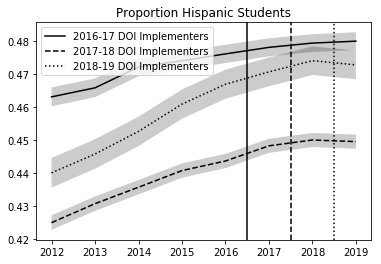

In [62]:
parallel_trends_graph('students_hisp', 'hispanic_by_adoption_score_std', '', 'Proportion Hispanic Students')

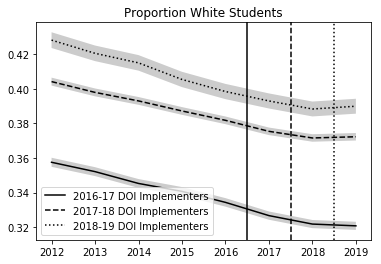

In [63]:
parallel_trends_graph('students_white', 'white_by_adoption_score_std', '', 'Proportion White Students')

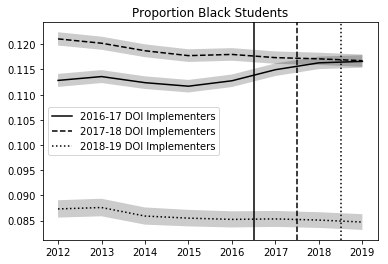

In [64]:
parallel_trends_graph('students_black', 'black_by_adoption_score_std', '', 'Proportion Black Students')

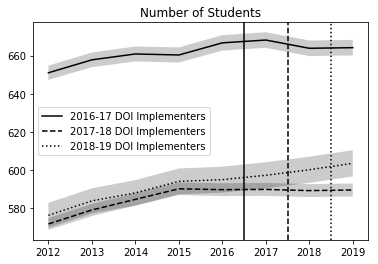

In [65]:
parallel_trends_graph('students_num', 'size_by_adoption_score_std', '', 'Number of Students')

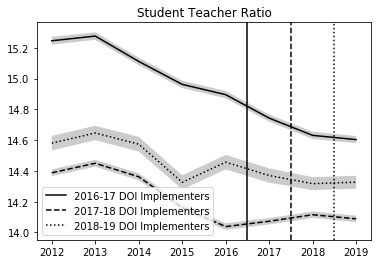

In [66]:
parallel_trends_graph('stu_teach_ratio', 'stu_teach_ratio_by_adoption_score_std', '', 'Student Teacher Ratio')

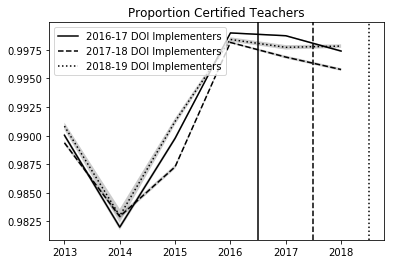

In [67]:
parallel_trends_graph('certification', 'certification_by_adoption_score_std', '', 'Proportion Certified Teachers')